<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">scRNA-Seq - Foetal Project</h1> 
    <h2 style="color:#483D8B;text-align:center;">Subsampling strategy - HSC vs CD-REF</h2>
    <br>02 September 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at860@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at19@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">   
    </body>
</html>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from matplotlib import cm
import matplotlib
import seaborn as sns
import sys, os

from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu
import math

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

np.warnings.filterwarnings('ignore')

In [2]:
fc   = scRNA_functions()

 * Initialising ...


# Functions

In [3]:
def combinations(data):
    
    if len(data[0])>len(data[1]):
        n = len(data[0])
        r = len(data[1])
    else:
        n = len(data[1])
        r = len(data[0])
        
    return math.factorial(n)/(math.factorial(r)*math.factorial(n-r))


def numberTests(dictionary, n_tests, cut_off):
    
    num_tests = n_tests
    
    keys1 = dictionary.keys()

    for key1 in keys1:
        
        keys2 = dictionary[key1].keys()
        
        for key2 in keys2:
            keys3 = list(dictionary[key1][key2].keys())
                                          
            data   = []
            labels = []
            for key3 in keys3:
                
                genes = dictionary[key1][key2][key3]
                
                if len(genes) >= cut_off:
                    data.append(genes)
                    labels.append(key3)
                      
            if len(data) > 1:
                
                for i, label1 in enumerate(labels):
                    for j, label2 in enumerate(labels):
                        if i<j:
                            d = [data[i], data[j]]
                            l = [label1, label2]
                            
                            comb = combinations(d)
                            if comb < num_tests:
                                num_tests = comb
    
    return int(num_tests)

In [4]:
def plotViolins(dfTests, dfKLs):
    
    palette1 = ["#0099ff", "#ac00e6"]
    palette2 = ["#0033cc", "#ff8000", "#ac00e6"]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    sns.set(font_scale=1.3)
    sns.set_style("white")
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax[0] = plt.subplot(gs[0])
    ax[1] = plt.subplot(gs[1])

    sns.violinplot(x="label",
                   y="p-value",
                   hue="Test",
                   data=dfTests,
                   palette=palette1,
                   split=True,
                   ax=ax[0],
                   scale="count",
                   cut=0)
    
    ax[0].set_xlabel("")
    ax[0].set_ylim([0,1])
        
    ax[0].axhline(0.01, linestyle="--", color="#202020")
    ax[0].text(0.495, 0.01, '$\\alpha=0.01$', fontsize=12, va='center', ha='left', color="#202020")
    
    ax[0].axhline(0.05, linestyle="--", color="#606060")
    ax[0].text(0.495, 0.05, '$\\alpha=0.05$', fontsize=12, va='center', ha='left', color="#606060")

    ax[0].axhline(0.1,  linestyle="--", color="#A9A9A9")
    ax[0].text(0.495, 0.1, '$\\alpha=0.1$', fontsize=12, va='center', ha='left', color="#A9A9A9")
        
    sns.violinplot(x="label",
                   y="value",
                   hue="Test",
                   data=dfKLs,
                   palette=palette2,
                   ax=ax[1],
                   scale="count",
                   cut=0)
    ax[1].set_xlabel("")
    
    sns.despine(offset=10, trim=False)

    plt.show(block=False)

def combinations(data):
    
    if len(data[0])>len(data[1]):
        n = len(data[0])
        r = len(data[1])
    else:
        n = len(data[1])
        r = len(data[0])
        
    return math.factorial(n)/(math.factorial(r)*math.factorial(n-r))
    

def numberTests(expr_genes, n_tests, cut_off):
    
    num_tests = n_tests
    
    keys1 = expr_genes.keys()

    for key1 in keys1:
        
        keys2 = expr_genes[key1].keys()
        
        for key2 in keys2:
            keys3 = list(expr_genes[key1][key2].keys())
                                          
            data   = []
            labels = []
            for key3 in keys3:
                
                genes = expr_genes[key1][key2][key3]
                
                if len(genes) >= cut_off:
                    data.append(genes)
                    labels.append(key3)
                      
            if len(data) > 1:
                
                for i, label1 in enumerate(labels):
                    for j, label2 in enumerate(labels):
                        if i<j:
                            d = [data[i], data[j]]
                            l = [label1, label2]
                            
                            comb = combinations(d)
                            if comb < num_tests:
                                num_tests = comb
    
    return int(num_tests)


def expressedGenes(adata, group_by1="gate", group_by2="origin", group_by3="sample", normalise=True):
    
    groups1 = np.unique(adata.obs[group_by1])
    
    dict_groups1 = {}
    for g1 in groups1:
        selected1 = adata[adata.obs[group_by1]==g1]
        groups2   = np.unique(selected1.obs[group_by2])
        dict_groups2 = {}
        for g2 in groups2:
            selected2 = selected1[selected1.obs[group_by2]==g2]
            groups3   = np.unique(selected2.obs[group_by3])
            dict_groups3 = {}
            for g3 in groups3:
                selected3 = selected2[selected2.obs[group_by3]==g3]
                
                if normalise:
                    genes = (selected3.obs.n_genes / selected3.obs.n_reads).tolist()
                else:
                    genes = selected3.obs.n_genes
                
                dict_groups3[g3] = genes
                
            dict_groups2[g2] = dict_groups3
        
        dict_groups1[g1] = dict_groups2
    
    return dict_groups1


def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 1e-16

    # You may want to instead make copies to avoid changing the np arrays.
    P = np.asarray(P) + epsilon
    Q = np.asarray(Q) + epsilon

    divergence = np.sum(P*np.log(P/Q))
    return abs(divergence)

def runTests(data, labels, n_tests):
    
    values1 = []
    values2 = []
    label1  = ''
    label2  = ''
    
    if len(data[0]) <= len(data[1]):
        values1 = data[0]
        label1  = labels[0]
        
        values2 = data[1]
        label2  = labels[1]
    
    else:
        values1 = data[1]
        label1  = labels[1]
        
        values2 = data[0]
        label2  = labels[0]
    
    p_valuesKS = []
    p_valuesMW = []
    kls        = []
    
    for n in range(n_tests):
        np.random.seed(seed=n)
        subsampled = np.random.choice(values2, size=len(values1), replace=False)

        
        p_valKS = ks_2samp(values1, subsampled)[-1]
        p_valMW = mannwhitneyu(values1, subsampled)[-1]
        
        kl      = KL(values1, subsampled)
                


        p_valuesKS.append(p_valKS)
        p_valuesMW.append(p_valMW)
        kls.append(kl)
        
    print("\t * Minimum       p-value KS: %.2e; p-value MW: %.2e"%(np.min(p_valuesKS),    np.min(p_valuesMW)))
    print("\t * Maximum       p-value KS: %.2e; p-value MW: %.2e"%(np.max(p_valuesKS),    np.max(p_valuesMW)))
    print("\t * Average       p-value KS: %.2e; p-value MW: %.2e"%(np.mean(p_valuesKS),   np.mean(p_valuesMW)))
    print("\t * Standard dev. p-value KS: %.2e; p-value MW: %.2e"%(np.std(p_valuesKS),    np.std(p_valuesMW)))
    print("\t * Median        p-value KS: %.2e; p-value MW: %.2e"%(np.median(p_valuesKS), np.median(p_valuesMW)))
    print()
    print("\t * Minimum       KL(P||Q): %.2e"%(np.min(kls)))
    print("\t * Maximum       KL(P||Q): %.2e"%(np.max(kls)))
    print("\t * Average       KL(P||Q): %.2e"%(np.mean(kls)))
    print("\t * Standard dev. KL(P||Q): %.2e"%(np.std(kls)))
    print("\t * Median        KL(P||Q): %.2e"%(np.median(kls)))
    
    return p_valuesKS, p_valuesMW, kls


def statisticalTests(adata,
                     group_by1="gate",
                     group_by2="origin",
                     group_by3="sample",
                     cut_off=10,
                     n_tests=10,
                     normalise=True):
    
    dataframeKS  = pd.DataFrame(columns=["group1", "group2", "annotation", "p-value"])
    dataframeWMW = pd.DataFrame(columns=["group1", "group2", "annotation", "p-value"])
    dictionaryOut = {}
    
    p_valsKS     = []
    group1KS     = []
    group2KS     = []
    variablesKS  = []
    
    p_valsWMW    = []
    group1WMW    = []
    group2WMW    = []
    variablesWMW = []
    
    expr_genes = expressedGenes(adata,
                                group_by1=group_by1,
                                group_by2=group_by2,
                                group_by3=group_by3,
                                normalise=normalise)
        
    keys1 = expr_genes.keys()
    
    num_tests = n_tests
    for key1 in keys1:
        
        keys2 = expr_genes[key1].keys()
        
        for idx2,key2 in enumerate(keys2):
            keys3 = list(expr_genes[key1][key2].keys())
                                          
            data   = []
            labels = []
            for key3 in keys3:
                
                genes = expr_genes[key1][key2][key3]
                
                if len(genes) >= cut_off:
                    data.append(genes)
                    labels.append(key3)
            
            if len(data) > 2:
                print('* Analysing ', end="")
                for idx in range(len(labels)):
                    if idx < len(labels)-1:
                        print('%s, '%labels[idx], end="")
                    else:
                        print('and %s of cluster %s'%(labels[idx], key2))
                
                        
            if len(data) > 1:
                if idx2 == 0:
                    print("\n************************************************** %s **************************************************"%key1)
                
                dfTests = pd.DataFrame()
                dfKLs   = pd.DataFrame()
                
                tests        = []
                KLs          = []
                test_names   = []
                KLs_names    = []
                labels_outTS = []
                labels_outKL = []
                
                list_tests = []
                for i, label1 in enumerate(labels):
                    for j, label2 in enumerate(labels):
                        if i<j:
                            print("\t\t\t\t\t\t %s vs %s\n"%(label1, label2))
                            d = [data[i], data[j]]
                            l = [label1, label2]
                            
                            num_tests = n_tests
                            comb = combinations(d)
                            if comb < num_tests:
                                num_tests = comb
                            
                            num_tests = int(num_tests)
                            
                            list_tests.append(num_tests)
                            
                            print("Running %d different sampling"%num_tests)
                            KS, MW, KL = runTests(d, l, num_tests)

                            tests += KS
                            tests += MW
                            KLs   += KL

                            print()
                            print()
                            
                                
                                
                            test_names += ["Kolmogorov-Smirnov"]*num_tests
                            test_names += ["Wilcoxon–Mann–Whitney"]*num_tests
                            KLs_names  += ["KL(P||Q)"]*num_tests

                            labels_outTS += ["%s vs %s"%(label1, label2)]*2*num_tests
                            labels_outKL += ["%s vs %s"%(label1, label2)]*num_tests
                                
                dfTests["p-value"] = tests
                dfTests["Test"]    = test_names
                dfTests["label"]   = labels_outTS
                
                dfKLs["value"]     = KLs
                dfKLs["Test"]      = KLs_names
                dfKLs["label"]     = labels_outKL
                
                
                dfTests.sort_values(by=["label"], inplace=True)
                dfKLs.sort_values(by=["label"], inplace=True)
                                
                plotViolins(dfTests, dfKLs)
                
                p_valsKS.append(np.median(dfTests[dfTests["Test"] == "Kolmogorov-Smirnov"]["p-value"]))
                p_valsWMW.append(np.median(dfTests[dfTests["Test"] == "Wilcoxon–Mann–Whitney"]["p-value"]))
                
                group1KS.append(labels[0])
                group1WMW.append(labels[0])

                group2KS.append(labels[1])
                group2WMW.append(labels[1])
                variablesKS.append(key1)
                variablesWMW.append(key1)
        
    dataframeKS["group1"]      = group1KS
    dataframeKS["group2"]      = group2KS
    dataframeKS["annotation"]  = variablesKS
    dataframeKS["p-value"]     = p_valsKS
    
    dataframeWMW["group1"]      = group1WMW
    dataframeWMW["group2"]      = group2WMW
    dataframeWMW["annotation"]  = variablesWMW
    dataframeWMW["p-value"]     = p_valsWMW

In [5]:
def __plotMedian(meds):

    fig = plt.figure(figsize=(12, 5))
    sns.set(font_scale=1.5)
    sns.set_style("white")
    
    sns.distplot(meds,
                 hist=True,
                 kde=False,
                 bins=int(len(meds)/2),
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})
    
    
    plt.xlabel("p-value")
    plt.ylabel('# occurrence')
    
    sns.despine(offset=10, trim=False)
    plt.tight_layout()
    plt.show(block=False)
    
    fig = plt.figure(figsize=(12, 5))
    sns.set(font_scale=1.5)
    sns.set_style("white")
    
    sns.distplot(meds,
                 hist=False,
                 kde=True,
                 bins=int(len(meds)/2),
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})
    
    
    plt.xlabel("p-value")
    plt.ylabel('Density')
    
    sns.despine(offset=10, trim=False)
    plt.tight_layout()
    plt.show(block=False)
    
def numberOfCells(adata, group_by1="annotated_merged", group_by2="group", group_by3="origin"):
    
    groups1 = np.unique(adata.obs[group_by1])
    
    dict_groups1 = {}
    for g1 in groups1:
        selected1 = adata[adata.obs[group_by1]==g1]
        groups2   = np.unique(selected1.obs[group_by2])
        dict_groups2 = {}
        for g2 in groups2:
            selected2 = selected1[selected1.obs[group_by2]==g2]
            groups3   = np.unique(selected2.obs[group_by3])
            dict_groups3 = {}
            for g3 in groups3:
                selected3 = selected2[selected2.obs[group_by3]==g3]
                
                dict_groups3[g3] = selected3.obs.index.tolist()
                
            dict_groups2[g2] = dict_groups3
        
        dict_groups1[g1] = dict_groups2
    
    return dict_groups1


def runTestsSub(adata, data, labels, n_tests, folder, title='', save=False, tolist=False):
    
    tests = {}
    
    values1 = []
    values2 = []
    label1  = ''
    label2  = ''
    
    if len(data[0]) <= len(data[1]):
        values1 = data[0]
        label1  = labels[0]
        
        values2 = data[1]
        label2  = labels[1]
    
    else:
        values1 = data[1]
        label1  = labels[1]
        
        values2 = data[0]
        label2  = labels[0]
    
    if save == True:
        
        if not os.path.exists(folder):
            os.makedirs(folder) 
        
        np.savetxt('%s/ShortGroup_%s.csv' %(folder, title+'_'+label1+'_vs_'+label2), 
                   values1, 
                   fmt='%s')
    
    long = adata[adata.obs.index.isin(values2)]
    
    print("Subsampling analyses ...")
    print("Running test: ")
    for n in range(n_tests):
        
        if n < n_tests-1:
            print("%d"%n, end=", ")
        else:
            print("%d"%n)
        
        np.random.seed(seed=n)
        subsampled = np.random.choice(values2, size=len(values1), replace=False)
        short      = adata[adata.obs.index.isin(subsampled)]
        
        long_g  = long.X[:,:]
        short_g = short.X[:,:]
        
        if tolist:
            pvals = ttest_ind(long_g.tolist(), short_g.tolist(), equal_var = False, axis=0)[1]
        else:
            pvals = ttest_ind(long_g, short_g, equal_var = False, axis=0)[1]

        pvals[np.isnan(pvals)] = 0.0
        
#         pvals = []
#         for gene in range(long.n_vars):
#             t1 = time.time()
#             long_g   = long.X[:, gene].flatten().tolist()
#             short_g  = short.X[:, gene].flatten().tolist()
#             t2 = time.time()
#             print(t2-t1)
            
#             if np.sum(long_g)==0.0 and np.sum(short_g) == 0.0:
#                 pval = 0.0
#             else:
#                 pval = ttest_ind(long_g, short_g, equal_var = False)[1]

#             pvals.append(pval)
                    
        median = np.median(pvals)
        
        tests[n] = [median, subsampled]
    
    print()
        
    return tests, label1, label2


def runSubsampling(subset, group_by1="annotated_merged", group_by2="group", group_by3="origin",
                   n_tests=101, cut_off = 20, save = True, folder = None, tolist=False):
    
    if folder is None:
        folder = "Documents"
    
    num_cells = numberOfCells(subset,
                              group_by1=group_by1,
                              group_by2=group_by2,
                              group_by3=group_by3)
    
    n_tests   = numberTests(num_cells, n_tests, cut_off)
    
    print("Running %d different sampling for each test"%n_tests)

    keys1 = num_cells.keys()

    num_tests = n_tests
    for key1 in keys1:

        keys2 = num_cells[key1].keys()


        for idx2,key2 in enumerate(keys2):


            keys3 = list(num_cells[key1][key2].keys())

            data   = []
            labels = []
            for key3 in keys3:

                cells = num_cells[key1][key2][key3]


                if len(cells) >= cut_off:
                    data.append(cells)
                    labels.append(key3)

            if len(data) > 2:
                print('* Analysing ', end="")
                for idx in range(len(labels)):
                    if idx < len(labels)-1:
                        print('%s, '%labels[idx], end="")
                    else:
                        print('and %s of cluster %s'%(labels[idx], key2))


            if len(data) > 1:
                if idx2 == 0:
                    print("\n************************************************** %s **************************************************"%key1)

                for i, label1 in enumerate(labels):
                    for j, label2 in enumerate(labels):
                        if i<j:
                            print("\t\t\t\t\t\t %s vs %s\n"%(label1, label2))
                            d = [data[i], data[j]]
                            l = [label1, label2]

                            t, short_label, long_label = runTestsSub(subset, d, l, n_tests, folder, title=key1, save=save, tolist=tolist)

                            medians = []

                            for key in t.keys():
                                medians.append(t[key][0])

                            __plotMedian(medians)

                            value = np.median(medians)
                            idx   = np.argwhere(medians == value).flatten()[0]
                            cells = t[idx][1]
                            if save == True:
                                np.savetxt('%s/Subsampled_%s.csv' %(folder, key1+'_'+short_label+'_vs_'+long_label), 
                                           cells, 
                                           fmt='%s')

# Loading the object

In [6]:
merged = sc.read_h5ad('../Data/ScanpyObjets/MergedAllSamples_annotated.h5ad')

In [7]:
merged.X = merged.layers['counts'].copy()

# HSC-MPPs: CDREF vs HSC

In [8]:
folder = "../MetaData/Resources/SubsamplingHSCvsCDREF"

In [9]:
subset = merged[merged.obs["Cluster"] == "HSC-MPPs"]

In [10]:
subset = subset[subset.obs["gate"].isin(['HSC', 'REF-PROG'])]


************************************************** HSC-MPPs **************************************************
						 HSC vs REF-PROG

Running 1001 different sampling
	 * Minimum       p-value KS: 2.37e-09; p-value MW: 1.11e-10
	 * Maximum       p-value KS: 3.02e-04; p-value MW: 2.53e-05
	 * Average       p-value KS: 1.42e-05; p-value MW: 6.80e-07
	 * Standard dev. p-value KS: 3.12e-05; p-value MW: 1.72e-06
	 * Median        p-value KS: 2.90e-06; p-value MW: 1.45e-07

	 * Minimum       KL(P||Q): 2.79e-04
	 * Maximum       KL(P||Q): 2.85e-01
	 * Average       KL(P||Q): 1.07e-01
	 * Standard dev. KL(P||Q): 4.70e-02
	 * Median        KL(P||Q): 1.05e-01




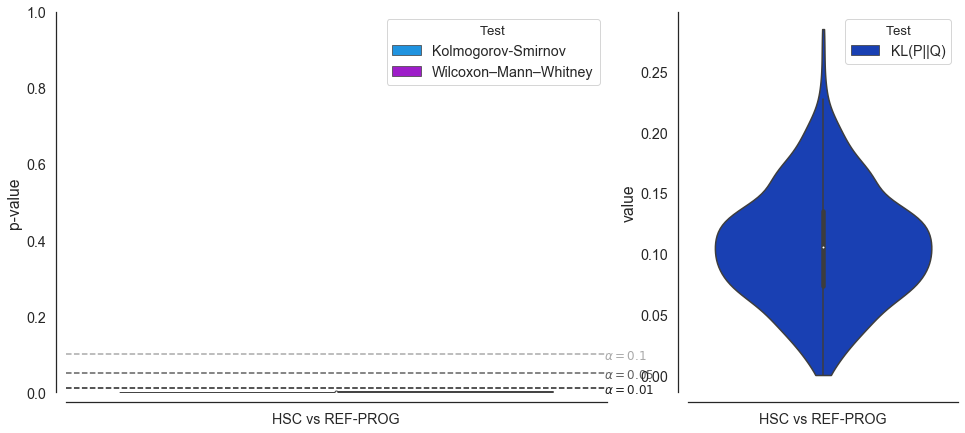


Running 1001 different sampling for each test

************************************************** HSC-MPPs **************************************************
						 HSC vs REF-PROG

Subsampling analyses ...
Running test: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 17

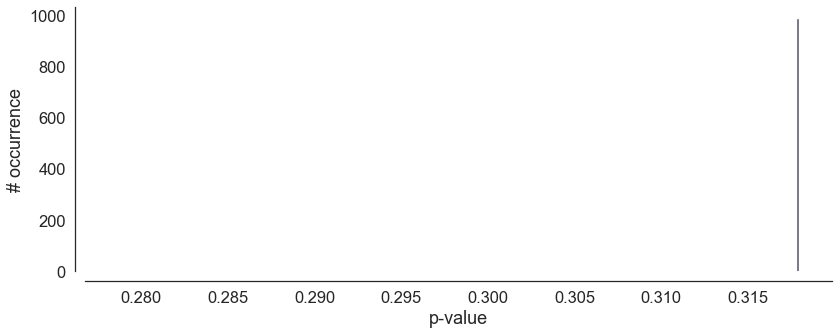

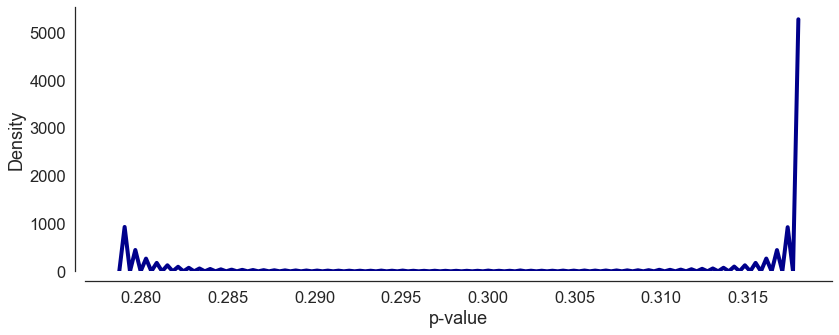

In [11]:
statisticalTests(subset,
                 group_by1 = "Cluster",
                 group_by2 = "Cluster",
                 group_by3 = "gate",
                 cut_off   = 20,
                 n_tests   = 1001
                )

print()

runSubsampling(subset,
               group_by1 = "Cluster",
               group_by2 = "Cluster",
               group_by3 = "gate",
               cut_off   = 20,
               n_tests   = 1001,
               folder    = folder,
               save      = True)

# HSC-MPPs: CDREF vs HSC (only femur)

In [12]:
folder = "../MetaData/Resources/SubsamplingHSCvsCDREF_femur"

In [13]:
subset = merged[merged.obs["Cluster"] == "HSC-MPPs"]

In [14]:
subset = subset[subset.obs["gate"].isin(['HSC', 'REF-PROG'])]
subset = subset[subset.obs["origin"]=="Femur"]


************************************************** HSC-MPPs **************************************************
						 HSC vs REF-PROG

Running 1001 different sampling
	 * Minimum       p-value KS: 4.27e-08; p-value MW: 8.78e-07
	 * Maximum       p-value KS: 1.00e-04; p-value MW: 1.09e-04
	 * Average       p-value KS: 1.41e-05; p-value MW: 1.75e-05
	 * Standard dev. p-value KS: 1.98e-05; p-value MW: 1.52e-05
	 * Median        p-value KS: 3.16e-06; p-value MW: 1.33e-05

	 * Minimum       KL(P||Q): 1.27e-04
	 * Maximum       KL(P||Q): 1.81e-01
	 * Average       KL(P||Q): 4.22e-02
	 * Standard dev. KL(P||Q): 2.67e-02
	 * Median        KL(P||Q): 3.88e-02




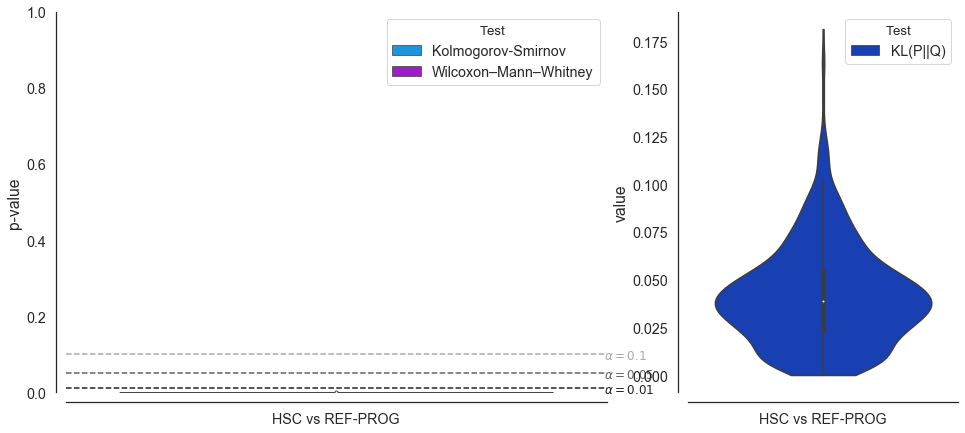


Running 1001 different sampling for each test

************************************************** HSC-MPPs **************************************************
						 HSC vs REF-PROG

Subsampling analyses ...
Running test: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 17

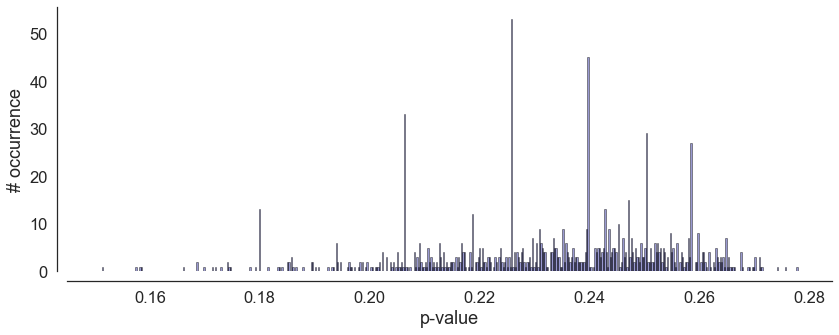

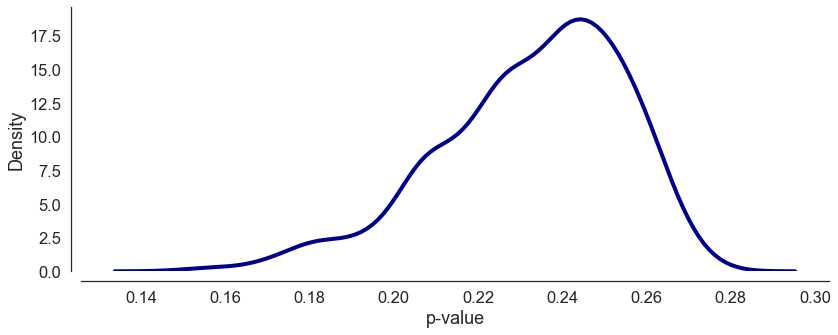

In [15]:
statisticalTests(subset,
                 group_by1 = "Cluster",
                 group_by2 = "Cluster",
                 group_by3 = "gate",
                 cut_off   = 20,
                 n_tests   = 1001
                )

print()

runSubsampling(subset,
               group_by1 = "Cluster",
               group_by2 = "Cluster",
               group_by3 = "gate",
               cut_off   = 20,
               n_tests   = 1001,
               folder    = folder,
               save      = True)